# Importing Needed Libraries


In [14]:
import keras, os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import regularizers
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from glob import glob
from IPython.display import display, Markdown, Latex
from sklearn.metrics import classification_report, confusion_matrix

# Prepare Data

In [3]:
paths=[]
for name in glob('/content/FruitRecognition/*', recursive=True):
  if not name.endswith('.zip'):
    paths.append(name)
paths

['/content/FruitRecognition/Tomatoes',
 '/content/FruitRecognition/Orange',
 '/content/FruitRecognition/Carambola',
 '/content/FruitRecognition/Plum',
 '/content/FruitRecognition/Pear',
 '/content/FruitRecognition/Apple',
 '/content/FruitRecognition/Banana',
 '/content/FruitRecognition/Peach',
 '/content/FruitRecognition/Pitaya',
 '/content/FruitRecognition/Guava',
 '/content/FruitRecognition/Pomegranate',
 '/content/FruitRecognition/Mango',
 '/content/FruitRecognition/Persimmon',
 '/content/FruitRecognition/Kiwi',
 '/content/FruitRecognition/model.json',
 '/content/FruitRecognition/model.h5',
 '/content/FruitRecognition/muskmelon']

In [4]:
img_paths=[]
extra_paths=[]
for i in paths:
  for name in glob(i+'/*'):
    if name.endswith('.png'):
      a=name.split('/')
      img_paths.append([name,a[-2]])
    else:
      extra_paths.append(name)
extra_paths

['/content/FruitRecognition/Apple/Apple F',
 '/content/FruitRecognition/Apple/Apple A',
 '/content/FruitRecognition/Apple/Apple B',
 '/content/FruitRecognition/Apple/Apple E',
 '/content/FruitRecognition/Apple/Apple D',
 '/content/FruitRecognition/Apple/Total Number of Apples',
 '/content/FruitRecognition/Apple/Apple C',
 '/content/FruitRecognition/Guava/Guava total',
 '/content/FruitRecognition/Guava/guava total final',
 '/content/FruitRecognition/Guava/guava A',
 '/content/FruitRecognition/Guava/guava B',
 '/content/FruitRecognition/Kiwi/kiwi A',
 '/content/FruitRecognition/Kiwi/Kiwi C',
 '/content/FruitRecognition/Kiwi/Kiwi B',
 '/content/FruitRecognition/Kiwi/Total Number of Kiwi fruit']

In [5]:
extra_imgs=[]
for i in extra_paths:
  if i=='/content/FruitRecognition/Apple/Total Number of Apples':
    for name in glob(i+'/*'):
      if name.endswith('.png'):
        extra_imgs.append([name,'Apple'])
  elif i=='/content/FruitRecognition/Guava/guava total final':
    for name in glob(i+'/*'):
      if name.endswith('.png'):
        extra_imgs.append([name,'Guava'])
  elif i=='/content/FruitRecognition/Kiwi/Total Number of Kiwi fruit':
    for name in glob(i+'/*'):
      if name.endswith('.png'):
        extra_imgs.append([name,'Kiwi'])
imgFinal=img_paths+extra_imgs
len(imgFinal)

43848

In [6]:
labels=[]
for i in range(len(imgFinal)):
  labels.append(imgFinal[i][1])
  imgFinal[i]=imgFinal[i][0]
set(labels)

{'Apple',
 'Banana',
 'Carambola',
 'Guava',
 'Kiwi',
 'Mango',
 'Orange',
 'Peach',
 'Pear',
 'Persimmon',
 'Pitaya',
 'Plum',
 'Pomegranate',
 'Tomatoes',
 'muskmelon'}

# Explore and Visualize Data to Gain Insights

#*Count Plot of data in data set:*

<Axes: xlabel='1', ylabel='count'>

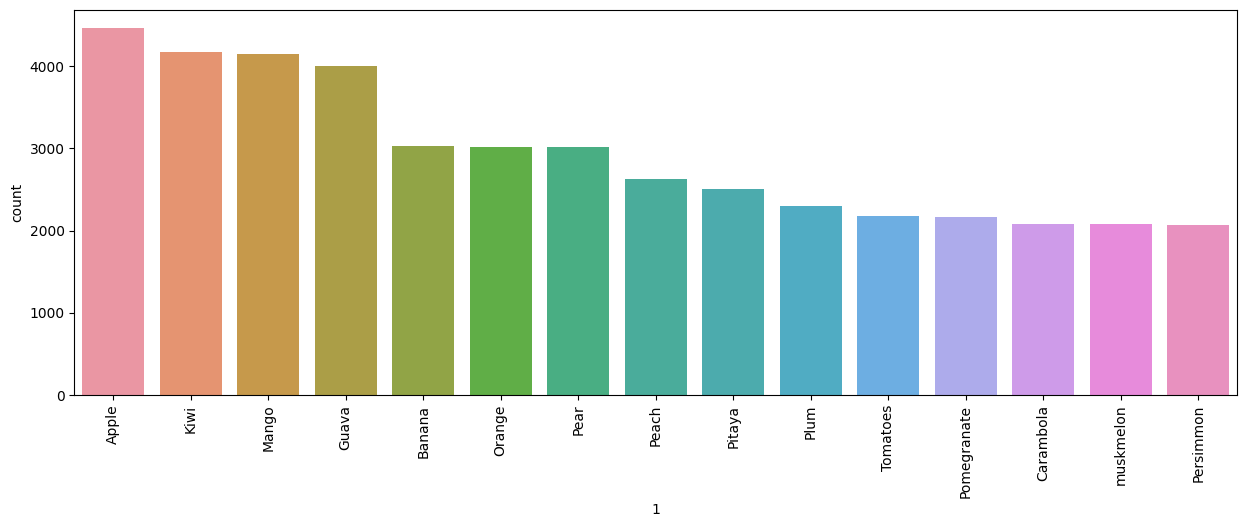

In [7]:
img_path = pd.Series(imgFinal).astype(str)
labels=pd.Series(labels)
data = pd.concat([img_path,labels],axis=1)
display(Markdown("#*Count Plot of data in data set:*"))
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.countplot(x=data[1], order=data[1].value_counts().index)

Dividing the dataset into training and testing

In [8]:
train_set , test_set = train_test_split(data,test_size=0.2, shuffle=True)

#*Count Plot of Training data in data set:*

<Axes: xlabel='1', ylabel='count'>

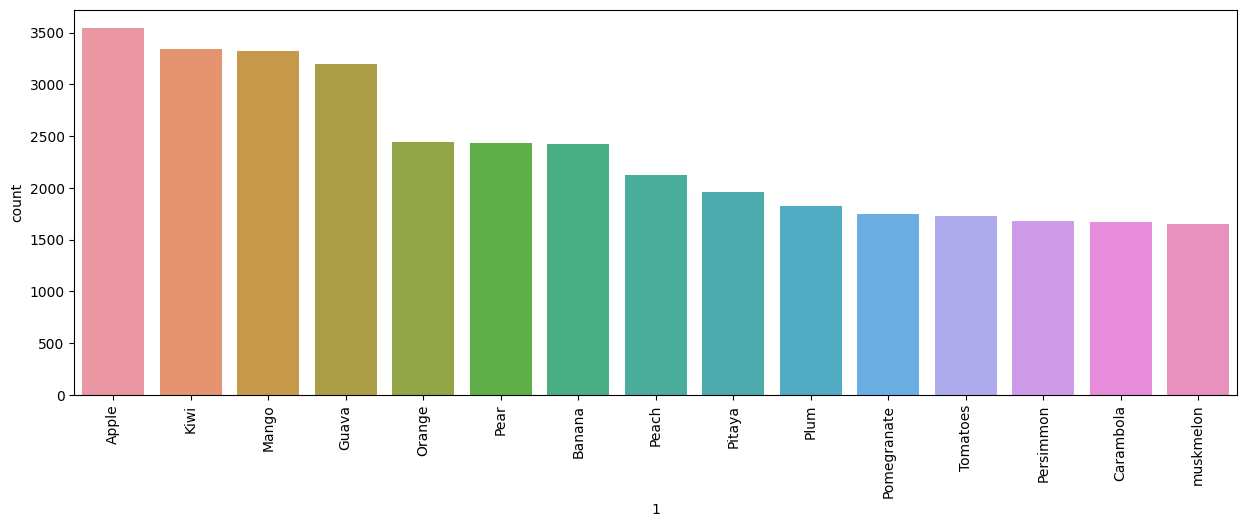

In [9]:
display(Markdown("#*Count Plot of Training data in data set:*"))
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.countplot(x=train_set[1], order=train_set[1].value_counts().index)

#*Count Plot of Testing data in data set:*

<Axes: xlabel='1', ylabel='count'>

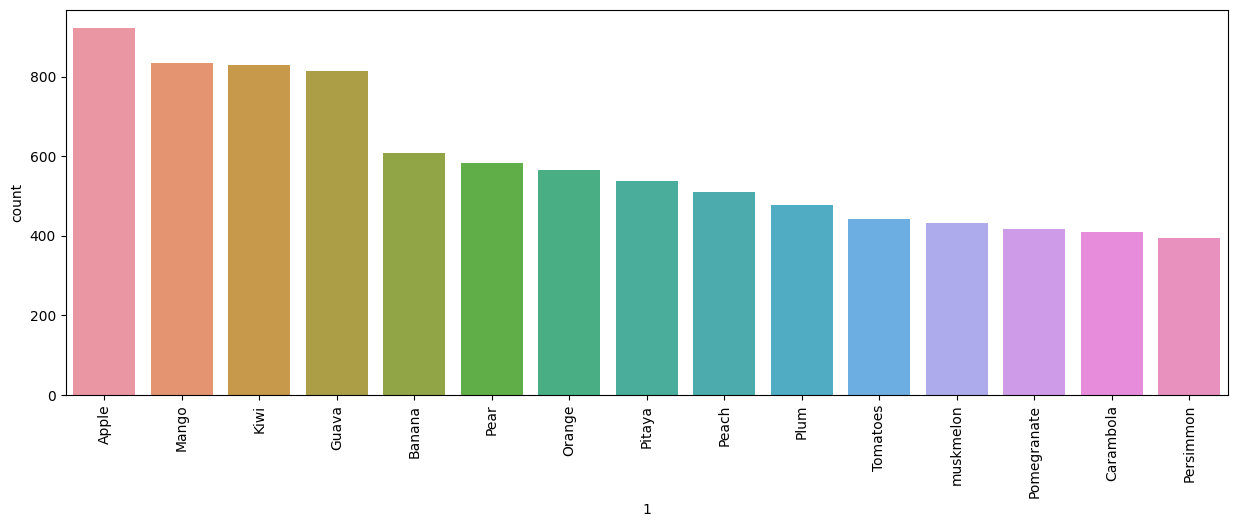

In [10]:
display(Markdown("#*Count Plot of Testing data in data set:*"))
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.countplot(x=test_set[1], order=test_set[1].value_counts().index)

# Model Implementation

*Loading and Preprocessing Data for Training, Validation, and Testing*

In [11]:
train_gen = ImageDataGenerator(validation_split=0.1)
test_gen = ImageDataGenerator()

train_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training'
)

val_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
)

test_data = test_gen.flow_from_dataframe(
    dataframe = test_set,
    x_col = 0,
    y_col = 1,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False
)

Found 31571 validated image filenames belonging to 15 classes.
Found 3507 validated image filenames belonging to 15 classes.
Found 8770 validated image filenames belonging to 15 classes.


*Loading and Compiling a Pre-trained CNN Model for Fruit Recognition*

In [18]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu", activity_regularizer=regularizers.L2(0.01)))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(units=15, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [19]:
model.compile(
    optimizer = tf.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
history = model.fit(train_data,epochs=10,validation_data=val_data)

Epoch 1/10
987/987 [==============================] - 454s 458ms/step - loss: 2.4795 - accuracy: 0.2543 - val_loss: 1.7740 - val_accuracy: 0.5555
Epoch 2/10
987/987 [==============================] - 461s 467ms/step - loss: 1.1856 - accuracy: 0.7538 - val_loss: 0.7889 - val_accuracy: 0.8466
Epoch 3/10
987/987 [==============================] - 445s 450ms/step - loss: 0.6791 - accuracy: 0.8660 - val_loss: 0.5431 - val_accuracy: 0.8956
Epoch 4/10
987/987 [==============================] - 444s 450ms/step - loss: 0.4750 - accuracy: 0.9141 - val_loss: 0.3823 - val_accuracy: 0.9390
Epoch 5/10
987/987 [==============================] - 446s 452ms/step - loss: 0.3428 - accuracy: 0.9447 - val_loss: 0.3174 - val_accuracy: 0.9438
Epoch 6/10
987/987 [==============================] - 441s 447ms/step - loss: 0.2490 - accuracy: 0.9680 - val_loss: 0.2302 - val_accuracy: 0.9661
Epoch 7/10
987/987 [==============================] - 440s 446ms/step - loss: 0.1894 - accuracy: 0.9812 - val_loss: 0.3561 -

*Visualizing Model Accuracy Over Epochs*

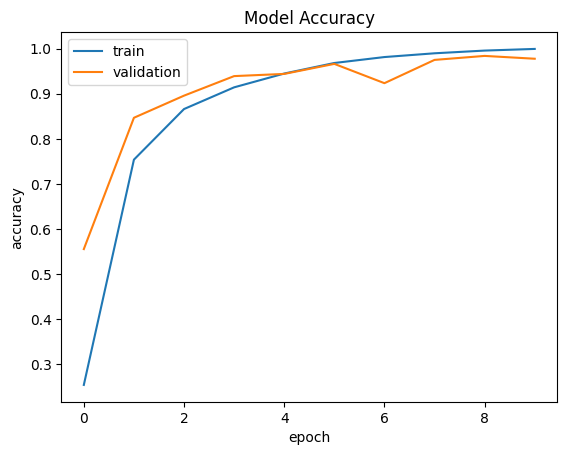

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

*Visualizing Model Loss Over Epochs*

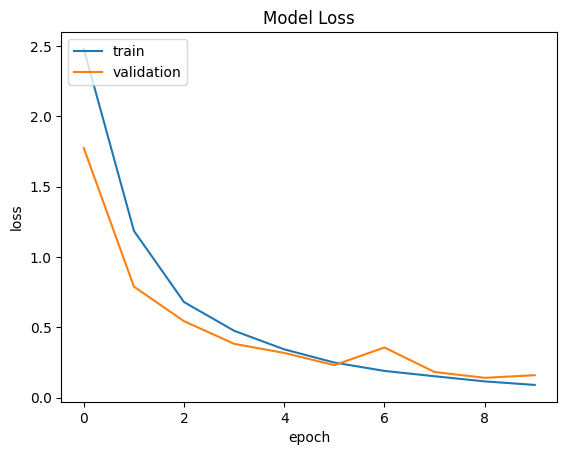

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model Evaluation

In [23]:
pred = model.predict(test_data)
pred = np.argmax(pred,axis=1)
print(classification_report(test_data.labels,pred))

275/275 [==============================] - 77s 278ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       922
           1       0.85      0.99      0.92       607
           2       1.00      0.83      0.91       409
           3       0.99      0.95      0.97       815
           4       1.00      1.00      1.00       828
           5       1.00      0.99      0.99       833
           6       1.00      0.99      1.00       566
           7       0.99      0.99      0.99       509
           8       0.90      0.98      0.94       582
           9       0.99      1.00      1.00       394
          10       0.99      1.00      1.00       538
          11       1.00      1.00      1.00       476
          12       0.99      0.97      0.98       417
          13       1.00      0.99      0.99       442
          14       0.97      0.93      0.95       432

    accuracy                           0.97      8770
   macro avg       0.9

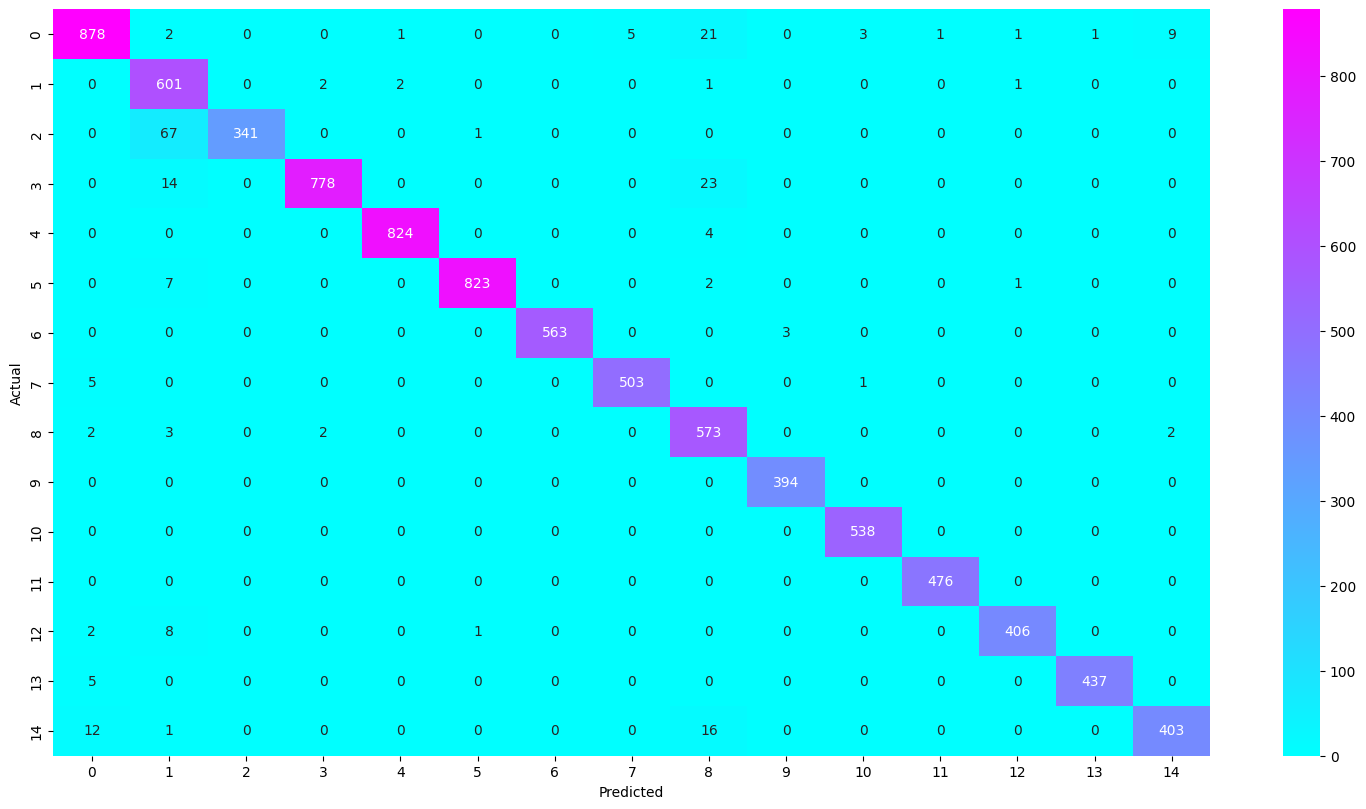

In [24]:
classes=[i for i in range(15)]
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,pred),
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(15, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [25]:
model_json = model.to_json()
with open("/content/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/model.h5")
print("Saved model to disk")

Saved model to disk


In [27]:
train_data.class_indices

{'Apple': 0,
 'Banana': 1,
 'Carambola': 2,
 'Guava': 3,
 'Kiwi': 4,
 'Mango': 5,
 'Orange': 6,
 'Peach': 7,
 'Pear': 8,
 'Persimmon': 9,
 'Pitaya': 10,
 'Plum': 11,
 'Pomegranate': 12,
 'Tomatoes': 13,
 'muskmelon': 14}

In [42]:
from skimage import io
#plt.imshow()
img = cv2.resize(io.imread("https://www.simplyrecipes.com/thmb/KDv2qjzCZUnaPGLQ-ddOUo5aqF0=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/__opt__aboutcom__coeus__resources__content_migration__simply_recipes__uploads__2005__11__pomegranate-horiz-a-1800-aabd491ecf0c4c1981406b571220cbfb.jpg"),(224,224))
img = np.expand_dims(img, axis=0)
model.predict(img)

1/1 [==============================] - 0s 19ms/step


array([[3.8111627e-01, 4.1828959e-04, 5.1914318e-04, 3.3374169e-04,
        3.4694394e-04, 3.8316473e-04, 2.8161244e-03, 6.6183275e-04,
        6.9944019e-04, 4.1308496e-03, 1.0425919e-02, 1.3093365e-03,
        1.7298752e-03, 5.9439832e-01, 7.1076106e-04]], dtype=float32)